# FDL 2019 - Floods

Flooding is a destructive, dangerous, and common hazard. Seventy-five percent of all Presidential disaster declarations are associated with flooding [1]. The work in this memorandum focuses specifically on river flooding. The National Oceanic and Atmospheric Administration's (NOAA's) 13 river forecast centers predict river levels at specific river locations up to several days in advance using hydrologic and hydraulic modeling. These forecasts can help cities prepare for and respond to river flooding events in the short-term. The Office of Water Prediction also prepares seasonal water forecasts at regional spatial resolution . The work presented here is complementary to these efforts and explores the efficacy of statistical -- instead of hydrological -- models for the prediction and forecasting of river flooding. 

The scope of this project focuses on two measures of flood susceptibility: predicting whether a specific river gauge site will flood in a given month, and the time to peak river level during a flood event. These questions were addressed from two perspectives. The first perspective assumes a well-gauged river basin and seeks to forecast the presence of a flood in the forthcoming month, or the time to peak river level for an ongoing rain event. The second perspective addresses the problem of predicting flood susceptibility in poorly gauged or entirely ungauged river basin. For these experiments, no prior river level information is incorporated into the predictive model. The river level data used to train the statistical models is made possible by the extensive network of stream gauges maintained by the US Geological Survey (USGS). Once the models are trained, they are used to construct maps of flood susceptibility, and the most important predictors of flood susceptibility from the statistical models are identified. 

The dataset was collected in 6 states over a period of 10 years between 2009.07-2019.07

Load in ml library and required datasets which include:

    -rainfall data from PRISM
    -Landcover information from NLCD
    -Basin Characteristics
    -Threshold Information per site
    -FLASH Flood data

must install xgboost,geopandas,rasterio,keras_metrics,jupyter nbextension enable --py --sys-prefix gmaps
pip install ipywidgets
jupyter nbextension enable --py widgetsnbextension

In [1]:
\l ml/ml.q 
\l ml/init.q
\l ml/fresh/notebooks/graphics.q

\l graphics.p
\l clust.q
\l models.q
\l columns_to_include.q
\l load_data.q

### Cleaning up the Dataset 

All site_no should be updated so that they have at least 8 digits. Any with less will be front loaded with 0's. Any nulls or infinity values from the dataset are also deleted

In [2]:
del:{![x;enlist (=;y;z);0b;`symbol$()]}
conv7_fn:{`$$[7=count x;"0",;]x}
precip:update conv7_fn each string each site_no from del[precipall;`ppt;0n]
maxht:update conv7_fn each site_no from del[max_ht_str;`height;neg[0w]]

Add in index column for the warnings table (will be used later for nearest neighbours)

In [3]:
warning:update nn:i from warnings

The PRISM dataset had an id limit of 12 digits, which means that some of the site_no digits were excluded. To not lose datapoints when joining, the remaining digits were added back in


In [4]:
rms:asc ds where 12<count each ds:exec distinct string each site_no from gauges 
names:0!select i by site_no from precip where site_no in `$12#'rms
matchnames:0!select i by lat,long from precip where i in names[`x][20]
lst1:til[26]except 21 22
lst2:til[25]except 20
i1:`$rms[lst1],rms[21 22]
i2:(names[`x]lst2),matchnames`x
precip:{![x;enlist(in;`i;z);0b;enlist[`site_no]!enlist enlist y]}/[precip;i1;i2]

## Feature Engineering

Seasonal Information plays an important role when predicting if an area will flood and how long it will take which is why the sin and cos of each month of the year is calculated

In [5]:
pi:acos -1
precip:update x:cos(lat)*cos(long),y:cos(lat)*sin(long),z:sin(lat) from precip
precip:`date xasc update month:`mm$date from precip
precip:update cos_t:cos 2*pi*(month-1)%11,sin_t:sin 2*pi*(month-1)%11 from precip
stryear:{$[x<2011;6;x<2016;11;16]}each `year$precip[`date]
precip:update year:stryear from precip

Inputs to the feature extraction function:

feat:

        -x   = table that's being updated
        -y   = how many values to calculate
        -z   = column to apply the function to 
        -col = new column name
        -d   = dictionary of where,groupby and what type of functional statement is used
        -fnc = function that is applied to the grouped columns


In [6]:
colname:{enlist`$string[y],"_",string[x],"_",string[z]}
m_avg:{(max;(mavg;y;x))}
prv:{(xprev;y;x)}

func:{[x;y;z;b]raze{[x;y;z;b]colname[x;y;z]!enlist b[x;z]}[z;y;;b]each raze x}
feat:{[x;y;z;col;d;fnc] d[`w][x;d`wh;d`gr;$[1<count[z];raze;]func[y;col;;fnc]each z]}

Knowing the upstream values is also an important feature to include into the dataset. The site_numbers are grouped by the first two digits with the remaining digits in ascending order

In [7]:
catch_site:((';#);2;($:;`site_no))
site_date:`site_no`date!(catch_site;`date)
dict:`w`wh`gr!(!;();site_date)
upstr_ppt:feat[precip;1;`ppt;`upstr;dict;prv]
upstr_height:feat[maxht;1;`height;`upstr;dict;prv]

Get the previous x days of rainfall and stream height for each row in the respective datasets

In [8]:
dict[`gr]:site:(enlist `site_no)!enlist `site_no
prev_rain:feat[upstr_ppt;enlist 1_til 10;`ppt`upstr_ppt_1;`prev;sited:dict;prv]
all_height:feat[upstr_height;enlist 1_til 10;`height`upstr_height_1;`prev;dict;prv]

The columns have been divided into three seperate sections:

    -ungauged basin with no perfect rain forecasts
    -gauged basins with no perfect rain forecasts
    -gauged basin with perfect rain forecasts

### Monthly Models

When forecasts are provided for each model, knowing how the average rainfall will change over differnet window sizes for each month is a feature that can be added to the dataset.

In [9]:
dict[`gr]:(`date`site_no)!(($;enlist`month;`date);`site_no)
all_rain:feat[prev_rain;enlist 1_til 15;`ppt`upstr_ppt_1;`window;dict;m_avg]

The dataset is then broken up into monthly values by taking the first day of each month at a given site

In [10]:
height_data:update date:"m"$date from select from all_height where 1=`dd$date
rain_data:update date:"m"$date from select from all_rain where 1=`dd$date

Join the stream height and rain data based on site number and month

In [11]:
monthly_data:height_data ij`site_no`date xkey rain_data

### Time to Peak Model

For the time to peak dataset the daily rain and height data is joined to the FLASH dataset based on the site number and date along with the stream_char dataset.

In [12]:
peak_data:(peak ij`date`site_no xkey prev_rain)ij`date`site_no xkey all_height

#### prev window

To make the times from the stream height dataset consistent with the FLASH dataset, the times have to be changed depending on the time zones.

These zones consist of 

    -EDT: Eastern Daylight Time
    -CDT: Central Daylight Time
    -EST: Eastern Standard Time

In [13]:
time_zone:raze{dd:x[1];si:x[0];
          select `$first site_no,`$first unk from str where date=first dd,si=`$site_no}each 
          value each 0!select date by distinct site_no from peak_data;
peak_data:peak_data ij`site_no xkey time_zone
change_zone:{$[y=`EDT;x-04:00;y=`CDT;x-05:00;x-06:00]}

In [14]:
peak_data[`start_time`end_time`peak_time]:change_zone''[;peak_data`unk]each peak_data`start_time`end_time`peak_time
peak_data[`date]:`date$peak_data`start_time

The previous hours before the flood event occurs can show information on how quickly the stream gauge height is moving which can be useful to the model in predicting how long it will take to peak. To do this the 2 days before the event are extracted, and moving averages of different sizes are applied to the stream height dataset

In [15]:
range:{(within;x;(,;(+;(-:;2);y);y))}
wh:{(range[`date;x[1]];range[`datetime;x[2]];(=;x[0];($;enlist`;`site_no)))}
dict:{`w`wh`gr!(?;wh x;0b)}
wind_ht_prev:{feat[str;enlist 2 4 12 48;`height;`wind_prev;dict x;m_avg]}each 
             flip peak_data[`site_no`date`start_time]

In [16]:
peak_data:peak_data,'raze wind_ht_prev
peak_data:del[peak_data;`wind_prev_height_2;neg[0w]]

For models that use rain forecasts,knowing what the coming days rainfall will be is also useful to add to the model

In [17]:
wh:{((within;`date;(,;y[1];(+;y[1];x)));(=;y[0];`site_no))}
dict:{`w`wh`gr!(?;wh[x;y];0b)}
rain_pred:{feat[all_rain;enlist 1_til x;`ppt`upstr_ppt_1;`fut_window;dict[x;y];m_avg]}[3]
          each flip peak_data[`site_no`date]
peak_data:peak_data,'raze rain_pred

## Target Data

### Monthly Models

The Flood level thresholds are obtained from the NOAA dataset. This dataset contains four warning level thresholds for a stream which are Action, Flood, Moderate and Major. The gauge sites are joined to a flood warning level using nearest neighbours

In [18]:
wlatl:raze each warning[`Latitude`Longitude],'gauges[`dec_lat_va`dec_long_v]
tabw:kd.buildtree[wlatl;2]
gauge_val:count[warning]+til count gauges
nnwarn:kd.nns[;tabw;(count[warning]#0),count[gauges]#1;flip wlatl;`edist]each gauge_val

In [19]:
joins:([site_no:gauges`site_no]nn:nnwarn[;0];ndw:nnwarn[;1])
floodlvl:(maxht ij joins)lj`nn xkey warning
floodlvl[`Action`Moderate`Flood`Major]:"F"$'floodlvl[`Action`Moderate`Flood`Major]

In [20]:
show threshold:0!select first Action,first Flood,first Moderate,first Major,no_Action:count where height>Action
              ,no_Flood:count where height>Flood,no_Mod:count where height>Moderate,no_Major:count where 
               height>Major by site_no,"m"$date from floodlvl

site_no  date    Action Flood Moderate Major no_Action no_Flood no_Mod no_Major
-------------------------------------------------------------------------------
01200000 2009.07 6      9     10       12    0         0        0      0       
01200000 2009.08 6      9     10       12    0         0        0      0       
01200000 2009.09 6      9     10       12    0         0        0      0       
01200000 2009.10 6      9     10       12    0         0        0      0       
01200000 2009.11 6      9     10       12    0         0        0      0       
01200000 2009.12 6      9     10       12    0         0        0      0       
01200000 2010.01 6      9     10       12    0         0        0      0       
01200000 2010.02 6      9     10       12    0         0        0      0       
01200000 2010.03 6      9     10       12    1         0        0      0       
01200000 2010.04 6      9     10       12    0         0        0      0       
01200000 2010.05 6      9     10       1

For the sake of this project, we only want to predict if the "Flood" level was reached or not for a site during a given month. Our target data is a binary label of whether this was reached or not.

Any site that floods more than 28 days per month is omitted from the dataset

In [21]:
threshold:select from threshold where no_Flood<28
threshold[`target]:threshold[`no_Flood]>0

### Time to Peak Model

After a major rain event, it is important to know how long to will take for the stream to reach peak height.

The FLASH dataset will be used as ground thruth, which highlights how long it will take to reach this peak height, only dates and site numbers used in the rain and height will be extracted.

In [22]:
peak_data[`delta_peak]:(peak_data[`peak_time]-peak_data[`start_time])*24

To predict how long it will take to flood, we have classified this problem as a binary class of whether or not it will take longer than 3 hours. This is important to know how long people have to evacuate from the area when a Flood warning is given.

In [23]:
peak_data[`target]:peak_data[`delta_peak]<3.5

## Joining the characteristics tables 

Join the basin characteristics to the NLCD landcover dataset based on site_no.

In [24]:
stream_char:nlcd ij`site_no xkey basin
all_peak_data:peak_data ij`site_no`year xkey stream_char
all_monthly_data:(monthly_data ij`site_no`year xkey stream_char)ij`site_no`date xkey threshold

#### Lagged features

For gauged basins, having knowledge of if an area has flooded in the past or not is also an important feature to extract

In [25]:
monthly_data:feat[all_monthly_data;enlist 1 12;`target;`lagged;sited;prv]
tgts:0!select site_no,no_Flood,date,cs:count date by site_no from all_monthly_data
all_monthly_data[`lagged_target_all]:raze{count[x]mavg raze x}each?[tgts;();();`no_Flood]

## Train Test Split

Delete any rows from the dataset that contains a null

In [26]:
del_null:{where not any each null x}
cleaned_monthly:all_monthly_data[del_null all_monthly_data]
cleaned_peak:   all_peak_data[del_null all_peak_data]

In [27]:
fnd_col:{x where x in y}
ungauged_noforecast_basinM:fnd_col[ungauged_noforecast_basin;cols cleaned_monthly]
gauged_basinM:             fnd_col[gauged_basin;cols cleaned_monthly]
perfect_forecastM:         fnd_col[perfect_forecast;cols cleaned_monthly]
ungauged_noforecast_basinP:fnd_col[ungauged_noforecast_basin;cols cleaned_peak]
gauged_basinP:             fnd_col[gauged_basin;cols cleaned_peak]
perfect_forecastP:         fnd_col[perfect_forecast;cols cleaned_peak]

In [28]:
ungauge: `M`P!(ungauged_noforecast_basinM;ungauged_noforecast_basinP)
gauge:   `M`P!(ungauge[`M],gauged_basinM;ungauge[`P],gauged_basinP)
forecast:`M`P!(gauge[`M],perfect_forecastM;gauge[`P],perfect_forecastP)

In [29]:
split_dict:{(!). flip(
  (`ungauged;flip x[ungauge[y]]);
  (`gauged;flip x[gauge[y]]);
  (`forecast;flip x[forecast[y]]))}

In [30]:
split_dict[all_monthly_data;`M]

ungauged| 7i  -0.959493  -0.2817326    456f 1.454468 0.7407  526.9086 0.1926 ..
gauged  | 7i  -0.959493  -0.2817326    456f 1.454468 0.7407  526.9086 0.1926 ..
forecast| 7i  -0.959493  -0.2817326    456f 1.454468 0.7407  526.9086 0.1926 ..


### Monthly Models

Split the train and test up by date, so that only past data is contained in the training set. A date was chosen so that 20 percent of the dataset is in the testing set

In [31]:
cutoff:update cutoff:min[date]+floor 0.8*max[date]-min[date] by site_no from cleaned_monthly
XtrainMi:select from cutoff where date<cutoff
ytrainM:exec target from cutoff where date<cutoff
XtestMi:select from cutoff where date>=cutoff
ytestM:exec target from cutoff where date>=cutoff

XtrainM:split_dict[XtrainMi;`M]
XtestM:split_dict[XtestMi;`M]

### Time to Peak Model

The time to peak data is separated so that sites do not appear in both the train and test dataset. To distribution the sum of the target per site is shown below. This dataset is separated into equally distributed bins and the train and test split is stratified by this split

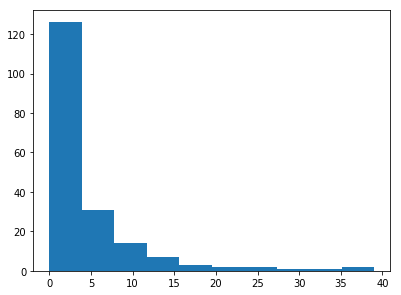

In [32]:
sites:0!select sum target by site_no from cleaned_peak
plt[`:hist][sites`target];
plt[`:show][];

In [33]:
train_test_split:.p.import[`sklearn.model_selection]`:train_test_split
bins:0 5 15 25.0
y_binned:bins bin`float$sites`target
tts:train_test_split[sites[`site_no];sites[`target];`test_size pykw 0.2; `random_state pykw 607;
    `shuffle pykw 1b;`stratify pykw y_binned]`;

In [34]:
cleaned_peak[`split]:`TRAIN
peak_split:update split:`TEST from cleaned_peak where site_no in`$tts[1]

In [35]:
XtrainPi:select from peak_split where split=`TRAIN
ytrainP:exec target from peak_split where split=`TRAIN
XtestPi:select from  peak_split where split=`TEST
ytestP:exec target from peak_split where split=`TEST

XtrainP:split_dict[XtrainPi;`P]
XtestP:split_dict[XtestPi;`P]

## Run Models

Gradient Boosts and Random forests were applied to the train and test datasets and the results were printed as a precision/recall curve. This metric was chosen as getting a balance between precision and recall when predicting floods is pivitol to ensure that all floods are given warnings but also not too many false warnings are given. The inputs to the pr_curve are

    -Xtest
    -ytest
    -dictionary of models that are being used


In [36]:
build_model:{[Xtrain;ytrain;dict]
 rf_clf:      RandomForestClassifier[`n_estimators pykw dict`rf_n;`random_state pykw 0;
            `class_weight pykw(0 1)!(1;dict`rf_wgt)][`:fit][Xtrain; ytrain];
 xgboost_clf: xgboost_clf: XGBClassifier[`n_estimators pykw dict`xgb_n;`learning_rate pykw 
              dict`xgb_lr;`random_state pykw 0;`scale_pos_weight pykw dict`xgb_wgt;
              `max_depth pykw dict`xgb_maxd][`:fit][np[`:array]Xtrain; ytrain];
 `random_forest`GBDT!(rf_clf;xgboost_clf)}

## Ungauged Prediction 

### Monthly Models


Accuracy for random_forest: 0.9390742
Meanclass accuracy for random_forest: 0.8513272


class    | precision recall    f1_score  support
---------| -------------------------------------
0        | 0.9427977 0.9949254 0.9681604 13203  
1        | 0.7598566 0.210109  0.3291925 1009   
avg/total| 0.8513272 0.6025172 0.6486765 14212  

Accuracy for GBDT: 0.9205713
Meanclass accuracy for GBDT: 0.6914636


class    | precision recall    f1_score  support
---------| -------------------------------------
0        | 0.9520138 0.9631902 0.9575694 13203  
1        | 0.4309133 0.3647175 0.3950617 1009   
avg/total| 0.6914636 0.6639539 0.6763155 14212  


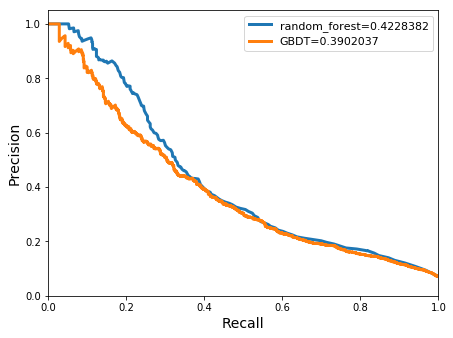

In [37]:
dict:`rf_n`rf_wgt`rf_maxd`xgb_n`xgb_lr`xgb_wgt`xgb_maxd!(200;1;8;200;.2;15;7)
pltU1:pr_curve[XtestM`ungauged;ytestM;build_model[XtrainM`ungauged;ytrainM;dict]]

### Time to Peak Model


Accuracy for random_forest: 0.7389706
Meanclass accuracy for random_forest: 0.7308405


class    | precision recall    f1_score  support
---------| -------------------------------------
0        | 0.7452632 0.9490617 0.8349057 373    
1        | 0.7164179 0.2840237 0.4067797 169    
avg/total| 0.7308405 0.6165427 0.6208427 542    

Accuracy for GBDT: 0.7702206
Meanclass accuracy for GBDT: 0.7376155


class    | precision recall    f1_score  support
---------| -------------------------------------
0        | 0.8109453 0.8739946 0.8412903 373    
1        | 0.6642857 0.5502959 0.6019417 169    
avg/total| 0.7376155 0.7121452 0.721616  542    


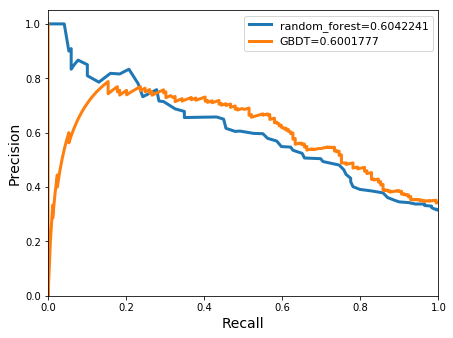

In [38]:
dict:`rf_n`rf_wgt`rf_maxd`xgb_n`xgb_lr`xgb_wgt`xgb_maxd!(100;1;17;350;.01;1.5;3)
pltU2:pr_curve[XtestP`ungauged;ytestP;build_model[XtrainP`ungauged;ytrainP;dict]]

## Gauged Prediction

### Monthly Models


Accuracy for random_forest: 0.9435768
Meanclass accuracy for random_forest: 0.9072401


class    | precision recall    f1_score  support
---------| -------------------------------------
0        | 0.9452222 0.9971976 0.9705145 13203  
1        | 0.869258  0.2438057 0.380805  1009   
avg/total| 0.9072401 0.6205017 0.6756597 14212  

Accuracy for GBDT: 0.9330941
Meanclass accuracy for GBDT: 0.7474907


class    | precision recall    f1_score  support
---------| -------------------------------------
0        | 0.9554036 0.9735666 0.9643996 13203  
1        | 0.5395778 0.4053518 0.4629315 1009   
avg/total| 0.7474907 0.6894592 0.7136656 14212  


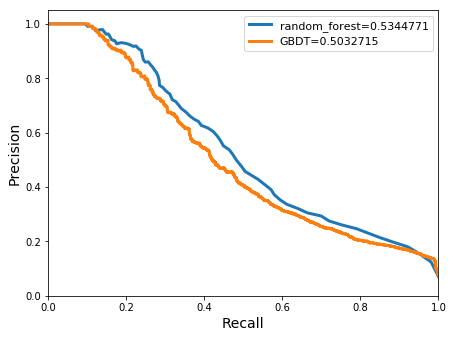

In [39]:
dict:`rf_n`rf_wgt`rf_maxd`xgb_n`xgb_lr`xgb_wgt`xgb_maxd!(100;16;8;100;0.2;16;9)
pltG1:pr_curve[XtestM`gauged;ytestM;build_model[XtrainM`gauged;ytrainM;dict]]

### Time to Peak Model

In [40]:
dict:`rf_n`rf_wgt`rf_maxd`xgb_n`xgb_lr`xgb_wgt`xgb_maxd!(100;1;17;360;0.01;1.5;3)
pltG2:pr_curve[XtestP`gauged;ytestP;build_model[XtrainP`gauged;ytrainP;dict]]


Accuracy for random_forest: 0.7205882
Meanclass accuracy for random_forest: 0.6982818


class    | precision recall    f1_score  support
---------| -------------------------------------
0        | 0.7298969 0.9490617 0.8251748 373    
1        | 0.6666667 0.2248521 0.3362832 169    
avg/total| 0.6982818 0.5869569 0.580729  542    

Accuracy for GBDT: 0.7610294
Meanclass accuracy for GBDT: 0.7325731


class    | precision recall    f1_score  support
---------| -------------------------------------
0        | 0.7868852 0.9008043 0.84      373    
1        | 0.6782609 0.4615385 0.5492958 169    
avg/total| 0.7325731 0.6811714 0.6946479 542    


## Perfect Forecast

### Monthly Models

In [41]:
dict:`rf_n`rf_wgt`xgb_n`xgb_lr`xgb_wgt`xgb_maxd!(100;15;100;0.2;15;7)
pltP1:pr_curve[XtestM`forecast;ytestM;build_model[XtrainM`forecast;ytrainM;dict]]


Accuracy for random_forest: 0.9437878
Meanclass accuracy for random_forest: 0.9119027


class    | precision recall    f1_score  support
---------| -------------------------------------
0        | 0.945234  0.9974248 0.9706283 13203  
1        | 0.8785714 0.2438057 0.3816912 1009   
avg/total| 0.9119027 0.6206153 0.6761598 14212  

Accuracy for GBDT: 0.9473758
Meanclass accuracy for GBDT: 0.8037618


class    | precision recall    f1_score  support
---------| -------------------------------------
0        | 0.9698273 0.9737938 0.9718065 13203  
1        | 0.6376963 0.6035679 0.6201629 1009   
avg/total| 0.8037618 0.7886809 0.7959847 14212  


### Time to Peak Model


Accuracy for random_forest: 0.7536765
Meanclass accuracy for random_forest: 0.7768992


class    | precision recall    f1_score  support
---------| -------------------------------------
0        | 0.7505198 0.9678284 0.8454333 373    
1        | 0.8032787 0.2899408 0.426087  169    
avg/total| 0.7768992 0.6288846 0.6357601 542    

Accuracy for GBDT: 0.7628676
Meanclass accuracy for GBDT: 0.7266119


class    | precision recall   f1_score  support
---------| ------------------------------------
0        | 0.8203125 0.844504 0.8322325 373    
1        | 0.6329114 0.591716 0.6116208 169    
avg/total| 0.7266119 0.71811  0.7219266 542    


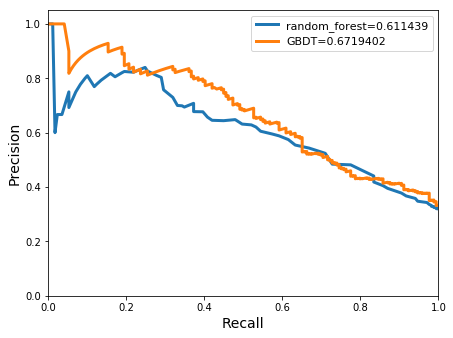

In [42]:
dict:`rf_n`rf_wgt`rf_maxd`xgb_n`xgb_lr`xgb_wgt`xgb_maxd!(100;1;17;300;0.01;2.5;3)
pltP2:pr_curve[XtestP`forecast;ytestP;build_model[XtrainP`forecast;ytrainP;dict]]

### Feature Significance

In [43]:
title:{"The top 15 significant features for the ",x," predicts are:"}

In [44]:
title["monthly"]
string .ml.fresh.significantfeatures[flip forecast[`M]!cleaned_monthly[forecast[`M]];
 cleaned_monthly`target;.ml.fresh.ksigfeat 15]

"The top 15 significant features for the monthly predicts are:"


"lagged_target_all"
"window_ppt_1"
"window_ppt_2"
"window_ppt_3"
"window_ppt_4"
"window_ppt_5"
"window_ppt_6"
"window_upstr_ppt_1_1"
"window_upstr_ppt_1_2"
"window_upstr_ppt_1_3"
"window_upstr_ppt_1_4"
"window_upstr_ppt_1_5"
"window_ppt_7"
"window_ppt_9"
"window_upstr_ppt_1_6"


In [45]:
title["time-peak"]
string .ml.fresh.significantfeatures[flip forecast[`P]!cleaned_peak[forecast[`P]];
 cleaned_peak`target;.ml.fresh.ksigfeat 15]

"The top 15 significant features for the time-peak predicts are:"


"WsAreaSqKmRp100"
"WsAreaSqKm"
"wind_prev_height_48"
"prev_upstr_height_1_1"
"wind_prev_height_12"
"prev_height_1"
"prev_height_5"
"WetIndexCat"
"prev_height_4"
"prev_height_6"
"prev_height_7"
"prev_height_2"
"prev_height_8"
"wind_prev_height_4"
"prev_height_3"


## Graphics 

In [46]:
preds:last pltP1`model
newtst:update preds:preds from XtestMi
newt:select from newtst where date within 2018.01 2018.12m,preds=1
dfnew:.ml.tab2df newt

In [47]:
graphs:.p.get`AcledExplorer
graphs[`df pykw dfnew][`:render][];

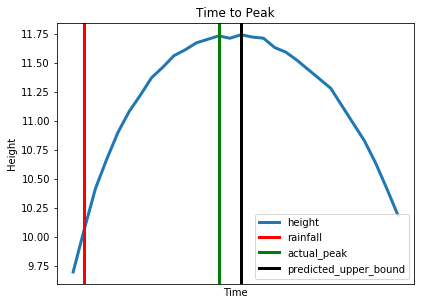

In [48]:
pred:last pltU2`model
pg:raze select site_no,start_time,end_time,peak_time from XtrainPi 
    where unk=`EDT,i in where pred=XtestPi`target,site_no=`02164110,
    target=1,delta_peak>2


rainfall:`x_val`col`title!(pg[`start_time];`r;`rainfall)
actual_peak:`x_val`col`title!(pg[`peak_time];`g;`actual_peak)
pred_bound:`x_val`col`title!(03:30+pg[`start_time];`black;`predicted_upper_bound)

graph:select from str where date within (`date$pg[`start_time];`date$pg[`end_time]), datetime
      within (neg[00:15]+pg[`start_time];[00:10]+pg[`end_time]),(value pg`site_no)=`$site_no

plt[`:plot][graph`datetime;graph`height;`label pykw `height;`linewidth pykw 3];
pltline:{plt[`:axvline][x`x_val;`color pykw x`col;`label pykw x`title;`linewidth pykw 3];}
pltline each (rainfall;actual_peak;pred_bound);

plt[`:legend][`loc pykw `best];
plt[`:title]["Time to Peak"];
plt[`:ylabel]["Height"];
plt[`:xlabel]["Time"];
plt[`:xticks][()];
plt[`:show][];

## Conclusion

From the above results we can predict with high accuracy whether an area will flood or not using particular models and input data

For the monthly models, the future weather predictions play an important role in predicting whether an area will flood or not, with the accuracy and other metrics such as recall and precision decreasing as the weather predictions and gauged information columns are excluded from the dataset. This corresponds with the results from the significant feature tests, with lagged_target_information and also the windowed rain values of the current month.

The opposite was true for the time-peak values, as previous rain and stream gauge information along with the basin characteristics were seen to be the most significant features when predicting these values. Including additional information about the future predicted rainfall decreased the accuracy of the results, with the best results being obtained from the model with only past rainfall and and basin and soil characteristics being fed into the model.

The best results from the models above were obtained by continuously adjusting the parameters of the model. The unbalanced target data in the monthly model meant that weighting the classes was an important feature to experiment with, in particular concerning trying to obtain high precision and recall results. In both models, the results between the recall and precision metrics were most balanced using xgboost.

Xgboost and Random Forests were favoured over neural net models as overfitting to the training set was a common feature with very low recall and precision results obtained. This was also seen in the raster results, where the models performed marginally better in the training set, but failed to pick up any meaningful results in the validation or testing set.


